<a href="https://colab.research.google.com/github/CynthiaWanyonyi/Phase4-Project-Image-Classification-with-Deep-Learning/blob/EDA/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import matplotlib.pyplot as plt
import random
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define paths
train_dir = '/content/drive/MyDrive/chest_xray/train'
val_dir = '/content/drive/MyDrive/chest_xray/val'
test_dir = '/content/drive/MyDrive/chest_xray/test'

Check the number of images in the train, test, and validation sets

In [6]:
train_normal_count = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
train_pneumonia_count = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
val_normal_count = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
val_pneumonia_count = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
test_normal_count = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
test_pneumonia_count = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))

print("Train Data:")
print(f"Normal Images: {train_normal_count}")
print(f"Pneumonia Images: {train_pneumonia_count}")

print("\nValidation Data:")
print(f"Normal Images: {val_normal_count}")
print(f"Pneumonia Images: {val_pneumonia_count}")

print("\nTest Data:")
print(f"Normal Images: {test_normal_count}")
print(f"Pneumonia Images: {test_pneumonia_count}")

Train Data:
Normal Images: 1342
Pneumonia Images: 3876

Validation Data:
Normal Images: 9
Pneumonia Images: 9

Test Data:
Normal Images: 234
Pneumonia Images: 390


 ## Exploratory Data Analysis (EDA)

**1. Class Distribution**

Check the distribution of images across classes (normal vs. pneumonia). This helps you understand if the classes are imbalanced.

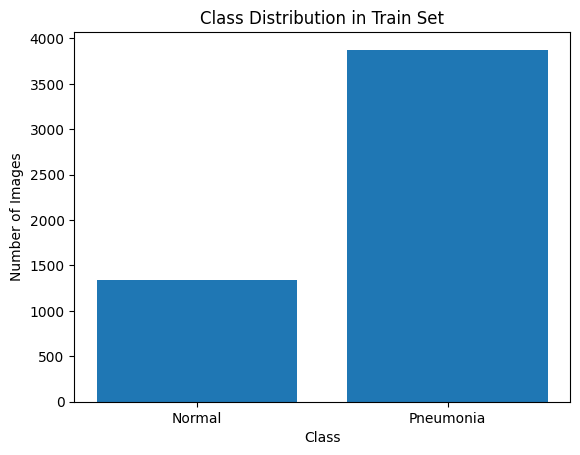

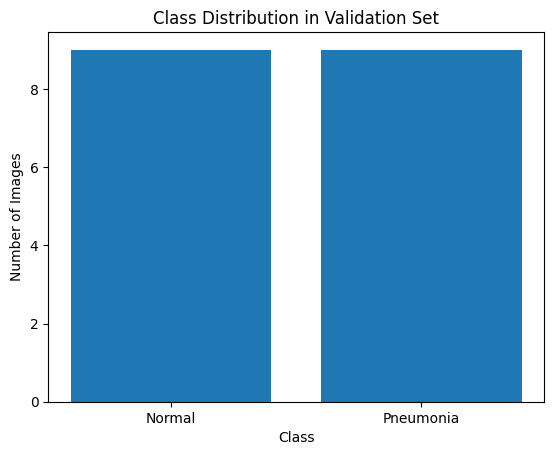

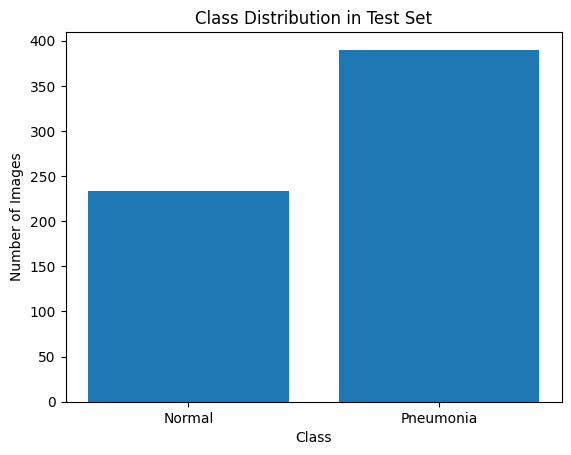

In [7]:
# Function to plot class distribution
def plot_class_distribution(normal_count, pneumonia_count, set_name):
    plt.bar(['Normal', 'Pneumonia'], [normal_count, pneumonia_count])
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title(f'Class Distribution in {set_name} Set')
    plt.show()

# Plot class distribution for each set
plot_class_distribution(train_normal_count, train_pneumonia_count, 'Train')
plot_class_distribution(val_normal_count, val_pneumonia_count, 'Validation')
plot_class_distribution(test_normal_count, test_pneumonia_count, 'Test')

* The training set seems to have an imbalanced class distribution, with significantly more pneumonia images than normal images.
* The validation set appears to have a very small number of images for both classes. This could potentially affect the model's ability to generalize effectively.
* The test set seems to have a more balanced distribution compared to the training set, with a relatively smaller number of pneumonia images compared to normal images.

**2. Sample Images**

Visualization of a few sample images from each class to get an idea of the data.

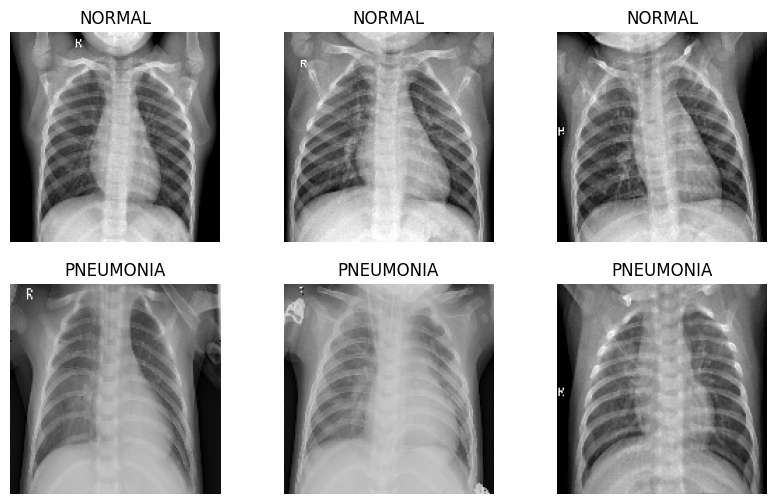

In [8]:
# Select random samples from both classes
normal_samples = random.sample(os.listdir(os.path.join(train_dir, 'NORMAL')), 3)
pneumonia_samples = random.sample(os.listdir(os.path.join(train_dir, 'PNEUMONIA')), 3)

# Display sample images
plt.figure(figsize=(10, 6))
for i, img_name in enumerate(normal_samples + pneumonia_samples):
    img_path = os.path.join(train_dir, 'NORMAL', img_name) if i < 3 else os.path.join(train_dir, 'PNEUMONIA', img_name)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('NORMAL' if i < 3 else 'PNEUMONIA')
plt.show()


* Normal images show healthy lungs without any signs of infection or abnormalities. Lung structures are well-defined, and the diaphragm appears intact.
* Pneumonia images depict lung infections with visible signs such as white patches (consolidation), increased density, hazy lung tissue (infiltrates), and more visible airways (air bronchograms).

**3. Image Dimensions**

Checking the dimensions of the images to ensure they are consistent and suitable for the model.

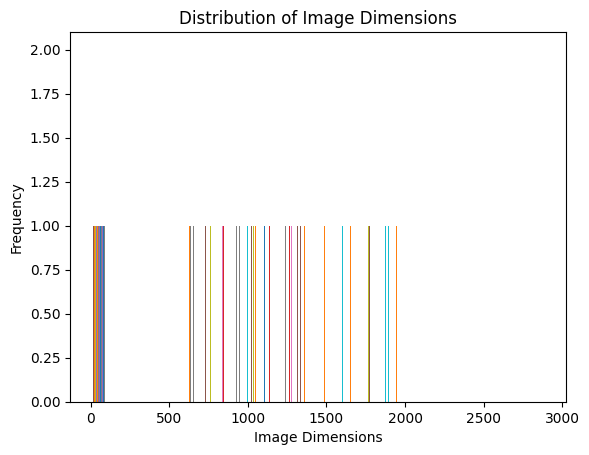

In [9]:
image_dims = []
sample_size = 100  # Number of images to sample

# Load and process images from both 'NORMAL' and 'PNEUMONIA' classes
for class_name in ['NORMAL', 'PNEUMONIA']:
    for img_name in os.listdir(os.path.join(train_dir, class_name))[:sample_size]:
        img_path = os.path.join(train_dir, class_name, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        image_dims.append(img_array.shape)

# Plot the distribution of image dimensions
plt.hist(image_dims, bins=30)
plt.xlabel('Image Dimensions')
plt.ylabel('Frequency')
plt.title('Distribution of Image Dimensions')
plt.show()


In the above histogram the frequency of the images seems to be the same for all the images but the dimensions seem to be different.
This means that we will have to determine a common target size that's compatible with the model we plan to use.

**4. Pixel Intensity Distribution**

Analyzing the pixel intensity distribution to check if there are any variations or anomalies.

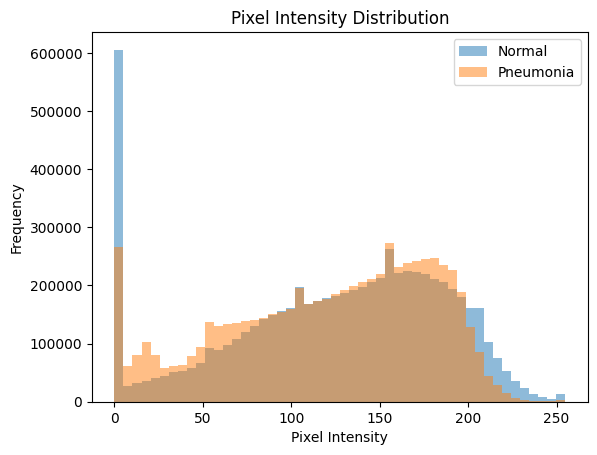

In [10]:
def load_and_flatten_images(directory, class_name, sample_size):
    pixel_values = []
    for img_name in os.listdir(os.path.join(directory, class_name))[:sample_size]:
        img_path = os.path.join(directory, class_name, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        pixel_values.extend(img_array.flatten())
    return pixel_values

sample_size = 100  # Number of images to sample
normal_pixel_values = load_and_flatten_images(train_dir, 'NORMAL', sample_size)
pneumonia_pixel_values = load_and_flatten_images(train_dir, 'PNEUMONIA', sample_size)

# Plot the pixel intensity distribution for both classes
plt.hist(normal_pixel_values, bins=50, alpha=0.5, label='Normal')
plt.hist(pneumonia_pixel_values, bins=50, alpha=0.5, label='Pneumonia')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.legend()
plt.show()



* Based on the histogram results, there is a wide distribution which indicates higher contrast and diverse intensity values.
* The 'Normal' class images exhibit a diverse range of pixel intensities while the 'Pneumonia' class images show higher intensities due to areas of opacity.



## Data augmentation and preprocessing

**1. Data Augmentation**

In the below we will perform data augmentation in order to introduce diversity into our training data, making the model less likely to overfit and more likely to generalize to unseen data.

In [11]:
# Data augmentation and preprocessing for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'  # How to fill newly created pixels
)

# Data preprocessing for the validation and test sets (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create generators
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


The validation and test data generators are created with only rescaling as they shouldn't undergo data augmentation.

**2. Handling Class Imbalance**

We will use class weights to give more importance to the underrepresented class.

In [12]:
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

During model training, we will pass class_weight=class_weights_dict to the fit function.

**3. Resizing Images**

Below we will resize the images to a consistent size that our model can handle efficiently.

In [13]:
target_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**4. Standardization**

We will perform standardization to bring the pixel values to a similar scale. This will be done by subtracting the mean and dividing by the standard deviation.


In [ ]:
# Calculate mean and standard deviation from the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure the same order as when calculating mean and std
)

num_samples = train_generator.samples
train_mean = np.zeros((3,))
train_std = np.zeros((3,))

for i in range(num_samples):
    batch = train_generator.next()
    train_mean += np.mean(batch[0], axis=(0, 1, 2))
    train_std += np.std(batch[0], axis=(0, 1, 2))

train_mean /= num_samples
train_std /= num_samples

# Standardize the data using mean subtraction and scaling by standard deviation
def standardize(x):
    return (x - train_mean) / train_std

# Apply standardization to generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    preprocessing_function=standardize
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    preprocessing_function=standardize
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    preprocessing_function=standardize
)


Found 5216 images belonging to 2 classes.
